Epoch [100/1000], Train Loss: 0.0301, Test Loss: 0.0404
Epoch [200/1000], Train Loss: 0.0196, Test Loss: 0.0180
Epoch [300/1000], Train Loss: 0.0159, Test Loss: 0.0332
Epoch [400/1000], Train Loss: 0.0140, Test Loss: 0.0140
Epoch [500/1000], Train Loss: 0.0129, Test Loss: 0.0103
Epoch [600/1000], Train Loss: 0.0116, Test Loss: 0.0119
Epoch [700/1000], Train Loss: 0.0109, Test Loss: 0.0083
Epoch [800/1000], Train Loss: 0.0103, Test Loss: 0.0111
Epoch [900/1000], Train Loss: 0.0097, Test Loss: 0.0092
Epoch [1000/1000], Train Loss: 0.0093, Test Loss: 0.0081
Final Test Loss: 0.0081


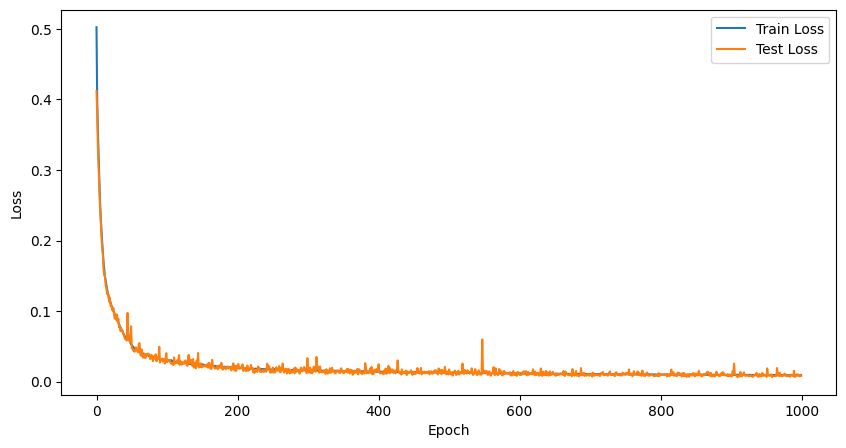

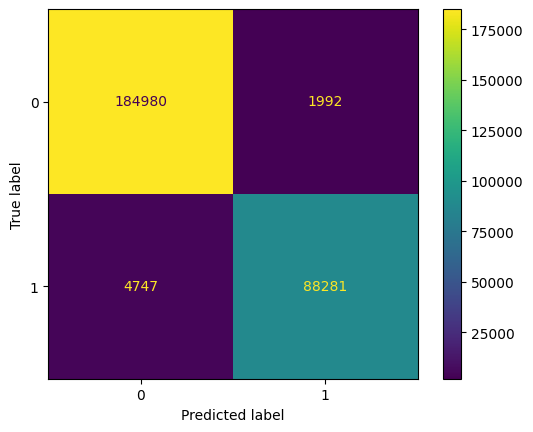

Model saved as model.pth


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the neural network model using nn.Sequential
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(25, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 14)
        )
        self.apply(self._init_weights)

    def forward(self, x):
        return self.model(x)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

# Custom dataset class
class SineWaveDataset(Dataset):
    def __init__(self, num_samples=None, input_file=None, output_file=None):
        if input_file and output_file:
            self.inputs, self.outputs = load_data(input_file, output_file)
        else:
            x = torch.rand(num_samples, dtype=torch.float32) * 2 * torch.pi
            self.inputs = torch.stack([x + i * 0.1 for i in range(25)], dim=1)
            self.outputs = torch.stack([torch.sin((i+1) * x) for i in range(14)], dim=1)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

def save_data(inputs, outputs, input_file='inputs.txt', output_file='outputs.txt'):
    np.savetxt(input_file, inputs.numpy())
    np.savetxt(output_file, outputs.numpy())

def load_data(input_file='inputs.txt', output_file='outputs.txt'):
    inputs = torch.tensor(np.loadtxt(input_file), dtype=torch.float32)
    outputs = torch.tensor(np.loadtxt(output_file), dtype=torch.float32)
    return inputs, outputs

def train_and_evaluate(model, criterion, optimizer, train_loader, test_loader, num_epochs):
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for inputs, outputs in train_loader:
            inputs, outputs = inputs.to(device), outputs.to(device)
            optimizer.zero_grad()
            predictions = model(inputs)
            loss = criterion(predictions, outputs)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on test set
        avg_test_loss, _, _ = evaluate(model, criterion, test_loader)
        test_losses.append(avg_test_loss)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses

def evaluate(model, criterion, data_loader):
    model.eval()
    total_loss = 0
    all_outputs = []
    all_predictions = []
    with torch.no_grad():
        for inputs, outputs in data_loader:
            inputs, outputs = inputs.to(device), outputs.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, outputs)
            total_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_predictions.append(predictions.cpu())
    
    avg_loss = total_loss / len(data_loader)
    all_outputs = torch.cat(all_outputs)
    all_predictions = torch.cat(all_predictions)
    return avg_loss, all_outputs, all_predictions

def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(outputs, predictions, num_classes=14):
    outputs = (outputs > 0.5).int()
    predictions = (predictions > 0.5).int()
    cm = confusion_matrix(outputs.view(-1), predictions.view(-1), labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.show()

# Parameters
num_samples = int(1e5)
num_epochs = 1000
batch_size = 32
input_file = 'inputs.txt'
output_file = 'outputs.txt'

# Generate and save dataset
if not (os.path.exists(input_file) and os.path.exists(output_file)):
    train_dataset = SineWaveDataset(num_samples)
    save_data(train_dataset.inputs, train_dataset.outputs, input_file, output_file)
else:
    train_dataset = SineWaveDataset(input_file=input_file, output_file=output_file)

# Create DataLoader with num_workers
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Separate dataset for validation/testing
test_dataset = SineWaveDataset(int(num_samples * 0.2))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Initialize the model, loss function, and optimizer
model = Net().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model and track losses
train_losses, test_losses = train_and_evaluate(model, criterion, optimizer, train_loader, test_loader, num_epochs)

print(f'Final Test Loss: {test_losses[-1]:.4f}')

# Plot training and test losses
plot_losses(train_losses, test_losses)

# Evaluate the model on the test dataset to get final outputs and predictions
_, test_outputs, test_predictions = evaluate(model, criterion, test_loader)

# Plot confusion matrix
plot_confusion_matrix(test_outputs, test_predictions)

# Save the model
torch.save(model.state_dict(), 'model.pth')
print('Model saved as model.pth')
